# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings_Augmented/vit_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.670779  0.595594 -0.077606 -0.107835 -0.272451  0.614318   
      201547  0.178823 -0.070760  0.129033  0.097289 -0.341705 -0.169392   
      201548  0.178823 -0.070760  0.129033  0.097289 -0.341705 -0.169392   
      201549  0.115743  0.208987 -0.220478  0.331592 -0.675573  0.333659   
      201550  0.418483  0.427503 -0.052307  0.207023 -0.309923  0.020332   

                     6         7         8         9  ...       759       760  \
41001 201546  0.272364 -0.507996  0.582110  0.648711  ... -0.004559  0.448523   
      201547 -0.289076 -0.028539  0.662626 -0.255299  ... -0.041063 -0.031891   
      201548 -0.289076 -0.028539  0.662626 -0.255299  ... -0.041063 -0.031891   
      201549 -0.207138  0.001534  0.521251  0.202988  ... -0.130802  0.613006   
      201550 -0.133146  0.439704  0.573165  0.189409  ... -0.190704  0.649817   

                   761       762       763       764       765       766  \
41001 201546 -0.235782  0.377595  0.668974  0.200040  0.354494 -0.052655   
      201547  0.650568  0.324353  0.543561 -0.020800  0.258195  0.007702   
      201548  0.650568  0.324353  0.543561 -0.020800  0.258195  0.007702   
      201549  0.048257  0.228138  0.315599 -0.356935  0.002624  0.135311   
      201550  0.365744 -0.030348  0.460557  0.005196  0.499655  0.143869   

                   767    Labels  
41001 201546  0.192024 -0.861740  
      201547  0.467435 -0.854589  
      201548  0.467435 -0.856973  
      201549  0.249216 -0.856973  
      201550  0.325766 -0.823600  

[5 rows x 769 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.166148 -0.281008  0.276551 -0.063237 -0.682747  0.447094   
      201821 -0.007424 -0.519584 -0.342950  0.125093  0.089374 -0.019499   
      201822 -0.290351 -0.523693 -0.111562 -0.135626 -0.422522 -0.633329   
      201823 -0.026328  0.393397  0.534254  0.159122  0.092003 -0.085724   
      201824  0.275765 -0.205492 -0.380056  0.379674 -0.283072  0.601271   

                     6         7         8         9  ...       759       760  \
41001 201820 -0.473513 -0.251758  0.058733 -0.078221  ... -0.209654  0.777690   
      201821  0.415618 -0.814556 -0.091747 -0.100127  ...  0.468053  0.710602   
      201822  0.263650 -0.756376 -0.439559 -0.136582  ...  0.694514  0.191799   
      201823 -0.030848 -0.383425 -0.121861 -0.552932  ...  0.131825  0.498413   
      201824  0.196244 -0.075560 -0.017773  0.234350  ...  0.407669  0.848582   

                   761       762       763       764       765       766  \
41001 201820  0.655789  0.141327 -0.054550 -0.180350 -0.127647 -0.447052   
      201821 -0.091668 -0.426610 -0.164857  0.193055 -0.037520  0.008214   
      201822 -0.029980 -0.294553 -0.315895  0.564754  0.535611 -0.131089   
      201823  0.304265  0.016069 -0.313765 -0.034732  0.336027 -0.021441   
      201824 -0.266996  0.237320 -0.072731 -0.465098 -0.310344  0.250170   

                   767    Labels  
41001 201820  0.154451 -0.949940  
      201821  0.876525 -0.961859  
      201822  0.183491 -0.940405  
      201823  0.559529 -0.961859  
      201824  0.350706 -0.954708  

[5 rows x 769 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 769)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 769)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 768)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 768)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

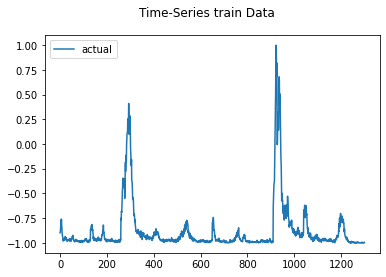

2023-03-13 21:24:18.349709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 21:24:18.349779: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 21:24:18.349884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-13 21:24:18.350184: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:24:18.462730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 57.531
Test RMSE: 73.883
Test sMAPE: 135.034
Test R Squared: -4.649
{'mae': 57.53138066187049, 'rmse': 73.88334202868474, 'smape': 135.03362306458632, 'r2': -4.64852513611351}


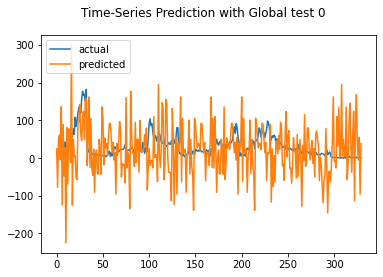

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 60.671
Test RMSE: 73.611
Test sMAPE: 128.903
Test R Squared: -4.607
{'mae': 60.67115073709777, 'rmse': 73.61100858717069, 'smape': 128.9031415611928, 'r2': -4.606961037923669}


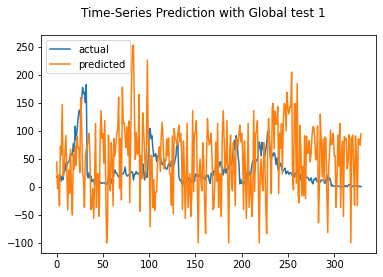

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.304
Test RMSE: 51.755
Test sMAPE: 102.937
Test R Squared: -1.772
{'mae': 40.304110153516135, 'rmse': 51.75451464643473, 'smape': 102.93743062635238, 'r2': -1.7716506037759294}


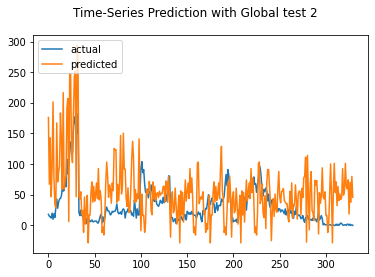

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 48.485
Test RMSE: 59.047
Test sMAPE: 123.013
Test R Squared: -2.608
{'mae': 48.484659459012924, 'rmse': 59.0473625282997, 'smape': 123.01256096869123, 'r2': -2.607804609627498}


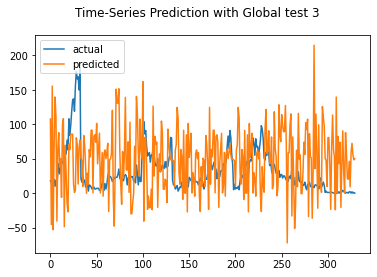

Test MAE: 72.147
Test RMSE: 117.487
Test sMAPE: 121.712
Test R Squared: -13.283
{'mae': 72.1471969620748, 'rmse': 117.4873768801939, 'smape': 121.71170212633164, 'r2': -13.283163797405498}


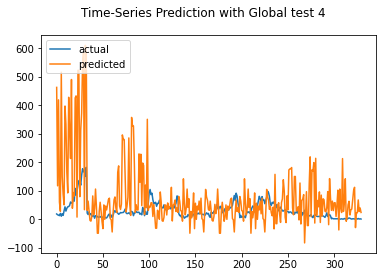

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 47.990
Test RMSE: 59.622
Test sMAPE: 109.704
Test R Squared: -2.678
{'mae': 47.98957300186157, 'rmse': 59.62170324595493, 'smape': 109.7035021164243, 'r2': -2.6783305899369485}


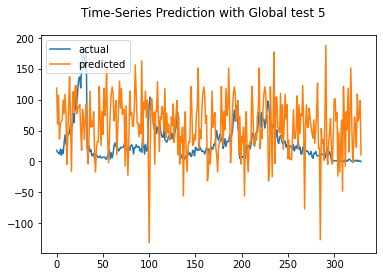

Test MAE: 47.432
Test RMSE: 61.042
Test sMAPE: 111.515
Test R Squared: -2.856
{'mae': 47.43214944763617, 'rmse': 61.0419045775559, 'smape': 111.5145512658222, 'r2': -2.8556548775141755}


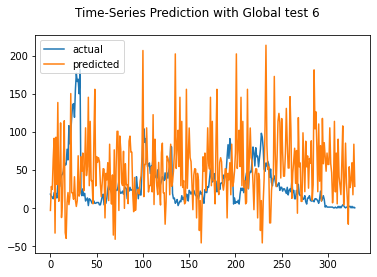

Test MAE: 51.203
Test RMSE: 64.301
Test sMAPE: 110.242
Test R Squared: -3.278
{'mae': 51.20284799716689, 'rmse': 64.30085785560753, 'smape': 110.24197921536512, 'r2': -3.2783423707456887}


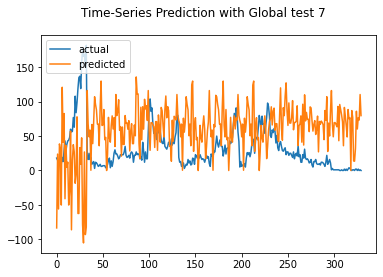

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 40.332
Test RMSE: 49.947
Test sMAPE: 95.770
Test R Squared: -1.581
{'mae': 40.33218773784059, 'rmse': 49.947184204597725, 'smape': 95.7701792151034, 'r2': -1.5814518036190113}


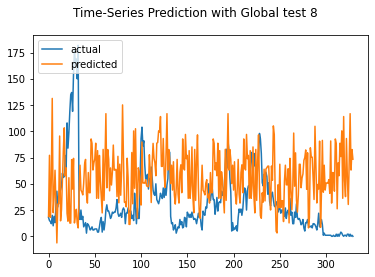

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 42.502
Test RMSE: 54.272
Test sMAPE: 108.131
Test R Squared: -2.048
{'mae': 42.50245829314897, 'rmse': 54.2716006757634, 'smape': 108.13089572805137, 'r2': -2.0478056035300742}


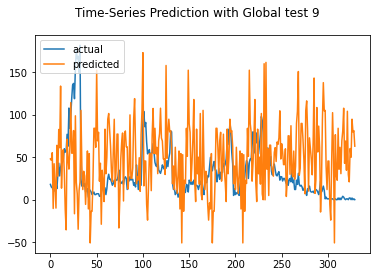

Test MAE: 48.763
Test RMSE: 58.218
Test sMAPE: 107.757
Test R Squared: -2.507
{'mae': 48.76274889310201, 'rmse': 58.21751697974921, 'smape': 107.75693206156524, 'r2': -2.507109765953746}


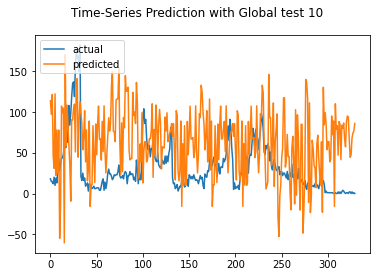

Test MAE: 49.596
Test RMSE: 68.010
Test sMAPE: 105.232
Test R Squared: -3.786
{'mae': 49.59564916021896, 'rmse': 68.00978772042617, 'smape': 105.23184225264971, 'r2': -3.7861338523159294}


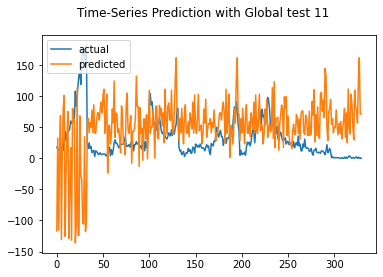

Test MAE: 66.333
Test RMSE: 104.277
Test sMAPE: 109.134
Test R Squared: -10.252
{'mae': 66.33303247437333, 'rmse': 104.2767164803529, 'smape': 109.13405275003461, 'r2': -10.251662492890619}


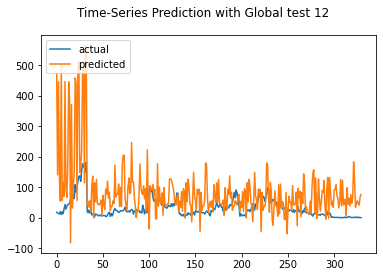

Test MAE: 51.820
Test RMSE: 63.327
Test sMAPE: 128.857
Test R Squared: -3.150
{'mae': 51.819751399394235, 'rmse': 63.32652484039853, 'smape': 128.8568894970134, 'r2': -3.1496676354275603}


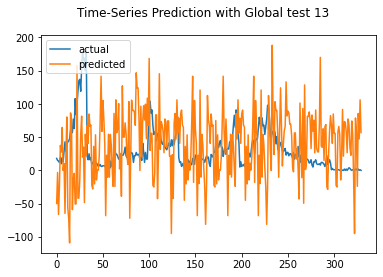

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 41.323
Test RMSE: 49.675
Test sMAPE: 100.762
Test R Squared: -1.553
{'mae': 41.3229135955825, 'rmse': 49.67545836092658, 'smape': 100.76223472945172, 'r2': -1.5534406493705677}


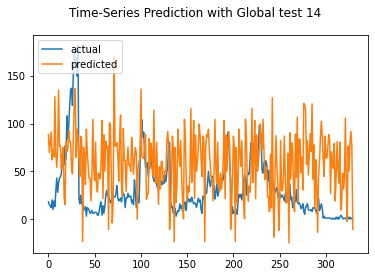

Test MAE: 86.586
Test RMSE: 108.041
Test sMAPE: 146.659
Test R Squared: -11.079
{'mae': 86.58633531675194, 'rmse': 108.04071028692086, 'smape': 146.659293398125, 'r2': -11.078607337100612}


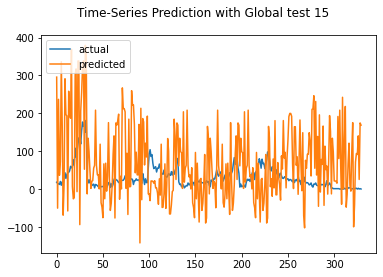

Test MAE: 63.888
Test RMSE: 93.865
Test sMAPE: 123.576
Test R Squared: -8.117
{'mae': 63.88783054496303, 'rmse': 93.86459062554005, 'smape': 123.57580924499561, 'r2': -8.116866228228137}


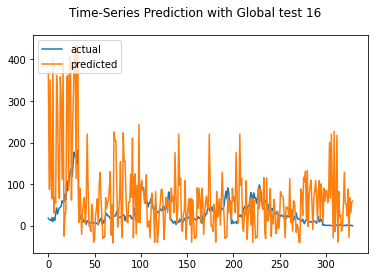

Test MAE: 45.104
Test RMSE: 53.587
Test sMAPE: 99.873
Test R Squared: -1.971
{'mae': 45.10388050332214, 'rmse': 53.58669509522798, 'smape': 99.8733086247932, 'r2': -1.9713646210435969}


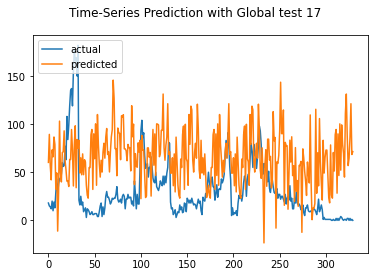

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 56.894
Test RMSE: 74.416
Test sMAPE: 123.624
Test R Squared: -4.730
{'mae': 56.894053872968215, 'rmse': 74.41625536777808, 'smape': 123.62434599048824, 'r2': -4.730303527708035}


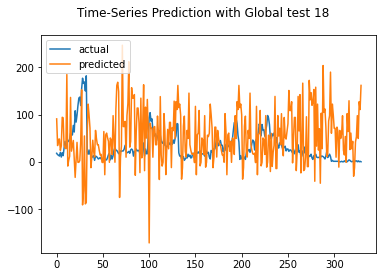

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 44.373
Test RMSE: 53.529
Test sMAPE: 102.533
Test R Squared: -1.965
{'mae': 44.37308636885701, 'rmse': 53.52909416478787, 'smape': 102.53304171076842, 'r2': -1.9649801489569079}


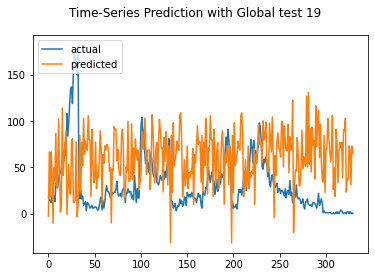

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.510
Test RMSE: 59.071
Test sMAPE: 107.465
Test R Squared: -2.611
{'mae': 47.50960019610145, 'rmse': 59.070738679923664, 'smape': 107.46516416269678, 'r2': -2.6106617493167446}


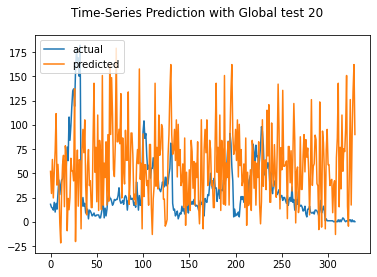

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.868
Test RMSE: 62.537
Test sMAPE: 122.289
Test R Squared: -3.047
{'mae': 50.868343557823785, 'rmse': 62.53723220666768, 'smape': 122.28906414218967, 'r2': -3.0468705639066673}


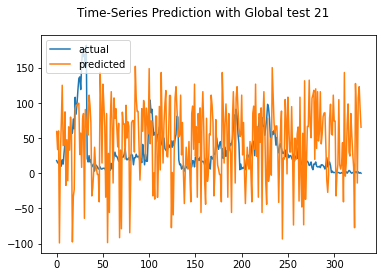

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')